In [1]:
import pandas as pd
import json
import os
import swifter
import argparse
import seaborn as sns

os.environ["DGLBACKEND"] = "pytorch"
import torch as th
import torch.nn.functional as F
import dgl
from dgl.data import DGLDataset
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from torch.utils.data.sampler import SubsetRandomSampler
from dgl.dataloading import GraphDataLoader
import torch.nn as nn

from tensorflow.keras.preprocessing.text import Tokenizer
from torchmetrics.classification import BinaryAccuracy
from torchmetrics.classification import BinaryPrecision

/home/barketr/.conda/envs/TreeLSTM_DGL/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-17 20:54:33.389597: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-17 20:54:34.893344: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-17 20:54:34.893407: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-17

In [2]:
if th.cuda.is_available():
    print("Available GPUs:")
    for i in range(th.cuda.device_count()):
        print(f"GPU {i}: {th.cuda.get_device_name(i)}")
else:
    print("No GPUs available.")

Available GPUs:
GPU 0: Quadro RTX 8000
GPU 1: Quadro RTX 8000


In [40]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
# Set the random seed for reproducibility
seed = 1998
th.manual_seed(seed)
dgl.seed(seed)

# Create a torch.Generator with the specified seed for random sampler
generator = th.Generator()
generator.manual_seed(seed)

# If using a GPU, set the seed for GPU as well
if th.cuda.is_available():
    th.cuda.manual_seed(seed)

In [6]:
TRIG = ['sin',
'cos',
'tan',
'cot',
'sec',
'scs',
'cosh',
'sinh',
'tanh',
'acos',
'asin',
'atan',
'acot',
'asec',
'ascs',
'acosh',
'asinh',
'atanh']

BIN_OP = ['add', 'sub', 'mul', 'div', 'pow']

# Load in data

In [2]:
import json

In [4]:
with open('Dataset/Train/BWD_train.json') as f:
    bwd_train = json.load(f)
with open('Dataset/Test/BWD_test.json') as f:
    bwd_test = json.load(f)
    
with open('Dataset/Train/FWD_train.json') as f:
    fwd_train = json.load(f)
with open('Dataset/Test/FWD_test.json') as f:
    fwd_test = json.load(f)

with open('Dataset/Train/IBP_train.json') as f:
    ibp_train = json.load(f)
with open('Dataset/Test/IBP_test.json') as f:
    ibp_test = json.load(f)
    
with open('Dataset/Train/SUB_train.json') as f:
    sub_train = json.load(f)
with open('Dataset/Test/SUB_test.json') as f:
    sub_test = json.load(f)
    
with open('Dataset/Train/RISCH_train.json') as f:
    risch_train = json.load(f)
with open('Dataset/Test/RISCH_test.json') as f:
    risch_test = json.load(f)

In [102]:
train_data = bwd_train + fwd_train + ibp_train + sub_train + risch_train
test_data = bwd_test + fwd_test + ibp_test + sub_test + risch_test

100000

In [72]:
df = pd.DataFrame(train_data, columns=['integrand', 'prefix', 'integral', 'label'])
df['graph_id'] = range(len(df))

In [73]:
df.head()

,integrand,prefix,integral,label,graph_id
0,2-2*x^3/(1+2*x)^2+3*x^2/(1+2*x),"[add, INT+, 2, add, mul, INT-, 2, mul, pow, x,...",x*(x^2+4*x+2)/(1+2*x),"[49, -1, -1, 49, 39, -1, 34, -1, -1, -1, -1, 43]",0
1,1/x/(x+ln(x))*(1+x+x/cos(x)^2*(x+ln(x))),"[mul, pow, x, INT-, 1, mul, pow, add, x, ln, x...",tan(x)+ln(x+ln(x)),"[-1, -1, 77, 107, -1, -1, 77, -1, -1, -1, -1, -1]",1
2,1/sin(x)^2*(-x*cos(x)+sin(x))*arctan(2),"[mul, pow, sin, x, INT-, 2, mul, add, mul, INT...",arctan(2)*x*csc(x),"[76, -1, 152, 106, 140, -1, 75, -1, -1, -1, -1...",2
3,x^2*sin(5)+2*x*(5+x)*sin(5),"[add, mul, pow, x, INT+, 2, sin, INT+, 5, mul,...",sin(5)*x^2*(5+x),"[63, -1, 71, 66, 71, -1, 71, -1, -1, -1, -1, 66]",3
4,1/ln(x)*(2-x)-x/ln(x)-1/ln(x)^2*(2-x),"[add, mul, pow, ln, x, INT-, 1, add, INT+, 2, ...",(-x^2+2*x)/ln(x),"[69, -1, 69, 69, 61, -1, 61, -1, -1, -1, -1, -1]",4


# Remove all duplicates
### Keep integers [-2,..,2] and replace rest with CONST for now 

In [74]:
# Custom function to replace integers with "CONST"
def replace_int_with_C(L):
    # L is a list of strings (prefix notation for expression)    
    keep_list = list(range(-2,3)) # dont replace these integers with CONST
    new_L = L.copy()
        
    for i in range(len(L)):
        if L[i].isdigit():
            
            if int(L[i]) not in keep_list:
                if len(L[i])==1: # 1 digit integers
                    new_L[i] = 'CONST1'
                elif len(L[i])==2: # 2 digit integers
                    new_L[i] = 'CONST2'
                else: # all other cases
                    new_L[i] = 'CONST3'
    return new_L

In [75]:
df['prefix'] = df['prefix'].apply(replace_int_with_C)

In [76]:
df

,integrand,prefix,integral,label,graph_id
0,2-2*x^3/(1+2*x)^2+3*x^2/(1+2*x),"[add, INT+, 2, add, mul, INT-, 2, mul, pow, x,...",x*(x^2+4*x+2)/(1+2*x),"[49, -1, -1, 49, 39, -1, 34, -1, -1, -1, -1, 43]",0
1,1/x/(x+ln(x))*(1+x+x/cos(x)^2*(x+ln(x))),"[mul, pow, x, INT-, 1, mul, pow, add, x, ln, x...",tan(x)+ln(x+ln(x)),"[-1, -1, 77, 107, -1, -1, 77, -1, -1, -1, -1, -1]",1
2,1/sin(x)^2*(-x*cos(x)+sin(x))*arctan(2),"[mul, pow, sin, x, INT-, 2, mul, add, mul, INT...",arctan(2)*x*csc(x),"[76, -1, 152, 106, 140, -1, 75, -1, -1, -1, -1...",2
3,x^2*sin(5)+2*x*(5+x)*sin(5),"[add, mul, pow, x, INT+, 2, sin, INT+, CONST1,...",sin(5)*x^2*(5+x),"[63, -1, 71, 66, 71, -1, 71, -1, -1, -1, -1, 66]",3
4,1/ln(x)*(2-x)-x/ln(x)-1/ln(x)^2*(2-x),"[add, mul, pow, ln, x, INT-, 1, add, INT+, 2, ...",(-x^2+2*x)/ln(x),"[69, -1, 69, 69, 61, -1, 61, -1, -1, -1, -1, -1]",4
...,...,...,...,...,...
99995,1/x^2*(4*x^2-x+3)/(-ln(x)-3-3/x+4*x),"[mul, pow, x, INT-, 2, mul, add, mul, INT+, CO...",ln(ln(x)-(4*x^2-3*x-3)/x),"[88, -1, -1, 78, 88, -1, 94, -1, -1, -1, -1, -1]",99995
99996,3/2/x^2/(8*x+3)*(24*x^4-7*x^3-87*x^2-133*x-21)...,"[add, mul, div, INT+, CONST1, INT+, 2, mul, po...",19/6*x+19/6-3/2*ln(exp(x+1)+(3*x^2-2*x-7)/(8*x...,"[205, 229, -1, 175, 205, -1, 217, -1, -1, -1, ...",99996
99997,1/3/x^2/(x^2-4*x+9)*(2*x^4-13*x^3+76*x^2-187*x...,"[add, mul, div, INT+, 1, INT+, CONST1, mul, po...",1/3*ln(ln(x^2)-(3*x+4)/(x^2-4*x+9))-3/5*ln(ln(...,"[185, -1, -1, 152, -1, -1, 193, -1, -1, -1, -1...",99997
99998,(-119400*x^8-3522810*x^7+19800*(-5+3*x)*x^7-22...,"[add, mul, add, mul, INT-, CONST3, pow, x, INT...",-1/(10*x^3+198*x^2-29*x+2)*(10*x-1)*x^3*(-5+3*...,"[-1, -1, -1, 175, -1, -1, 506, -1, -1, -1, -1,...",99998


In [78]:
# Remove any duplicates from dataset

df["prefix"] = df["prefix"].transform(lambda k: tuple(k))  # transforming to tuple is much faster operation
df.drop_duplicates(subset='prefix', inplace=True)
df['prefix'] = df['prefix'].apply(list)

In [80]:
df.head()

,integrand,prefix,integral,label,graph_id
0,2-2*x^3/(1+2*x)^2+3*x^2/(1+2*x),"[add, INT+, 2, add, mul, INT-, 2, mul, pow, x,...",x*(x^2+4*x+2)/(1+2*x),"[49, -1, -1, 49, 39, -1, 34, -1, -1, -1, -1, 43]",0
1,1/x/(x+ln(x))*(1+x+x/cos(x)^2*(x+ln(x))),"[mul, pow, x, INT-, 1, mul, pow, add, x, ln, x...",tan(x)+ln(x+ln(x)),"[-1, -1, 77, 107, -1, -1, 77, -1, -1, -1, -1, -1]",1
2,1/sin(x)^2*(-x*cos(x)+sin(x))*arctan(2),"[mul, pow, sin, x, INT-, 2, mul, add, mul, INT...",arctan(2)*x*csc(x),"[76, -1, 152, 106, 140, -1, 75, -1, -1, -1, -1...",2
3,x^2*sin(5)+2*x*(5+x)*sin(5),"[add, mul, pow, x, INT+, 2, sin, INT+, CONST1,...",sin(5)*x^2*(5+x),"[63, -1, 71, 66, 71, -1, 71, -1, -1, -1, -1, 66]",3
4,1/ln(x)*(2-x)-x/ln(x)-1/ln(x)^2*(2-x),"[add, mul, pow, ln, x, INT-, 1, add, INT+, 2, ...",(-x^2+2*x)/ln(x),"[69, -1, 69, 69, 61, -1, 61, -1, -1, -1, -1, -1]",4


# Convert the length of each sub-algo to binary classification

In [81]:
def change_to_binary(L):
    lowest_positive = min(filter(lambda x: x > 0, L), default=None)
    return [1 if x == lowest_positive else 0 for x in L]

In [82]:
df['label'] = df['label'].apply(change_to_binary)

In [83]:
df['label'].head()

0    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
1    [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]
2    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
3    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
4    [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0]
Name: label, dtype: object

# Plot counts of each sub-algo

In [84]:
count = {
    'default': 0, 
    'ddivides': 0, 
    'risch': 0,
    'norman': 0,
    'trager': 0,
    'meijerg': 0, 
    'elliptic': 0, 
    'lookup': 0,
    'gosper': 0,
    'parts': 0,
    'pseudoelliptic': 0,
    'parallelrisch': 0
}


In [85]:
for L in df['label']:
    if L[0]==1:
        count['default'] += 1
    if L[1]==1:
        count['ddivides'] += 1
    if L[2]==1:
        count['parts'] += 1    
    if L[3]==1:
        count['risch'] += 1
    if L[4]==1:
        count['norman'] += 1
    if L[5]==1:
        count['trager'] += 1
    if L[6]==1:
        count['parallelrisch'] += 1
    if L[7]==1:
        count['meijerg'] += 1
    if L[8]==1:
        count['elliptic'] += 1
    if L[9]==1:
        count['pseudoelliptic'] += 1
    if L[10]==1:
        count['lookup'] += 1
    if L[11]==1:
        count['gosper'] += 1

In [86]:
count

{'default': 49046,
 'ddivides': 16094,
 'risch': 44875,
 'norman': 26239,
 'trager': 1918,
 'meijerg': 928,
 'elliptic': 112,
 'lookup': 367,
 'gosper': 13932,
 'parts': 22224,
 'pseudoelliptic': 469,
 'parallelrisch': 31376}

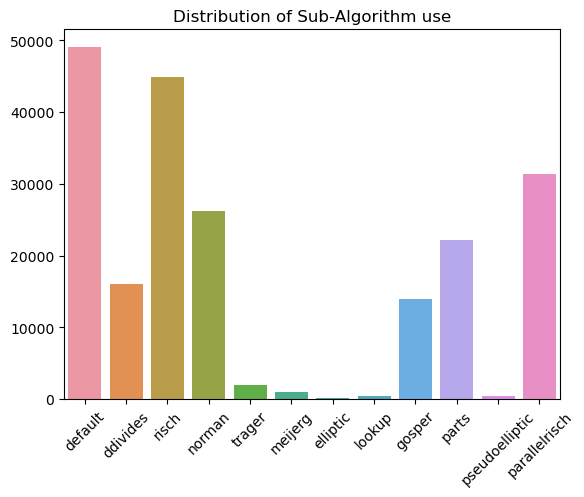

In [87]:
plt = sns.barplot(x=list(count.keys()), y=list(count.values()))
plt.set_title("Distribution of Sub-Algorithm use")
for item in plt.get_xticklabels():
    item.set_rotation(45)

# Create Embedding

In [88]:
word_list = [word for expr in df['prefix'] for word in expr[0]]
vocab_size = len(set(word_list)) # include all words
x_size = round(1.6*9) # https://ai.stackexchange.com/questions/28564/how-to-determine-the-embedding-size#:~:text=If%20we're%20in%20a,and%20no%20less%20than%20600.
max_len = max([len(word[1]) for word in train_data])

In [89]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(df['prefix'])

In [90]:
tokenizer.word_index

{'OOV': 1,
 'int+': 2,
 'mul': 3,
 'x': 4,
 'add': 5,
 'int-': 6,
 'const1': 7,
 'pow': 8,
 '1': 9,
 '2': 10,
 'const2': 11,
 'div': 12,
 'const3': 13,
 'exp': 14,
 'ln': 15,
 'cos': 16,
 'sin': 17,
 'tan': 18,
 'cosh': 19,
 'sinh': 20,
 'tanh': 21,
 'atan': 22,
 'acos': 23,
 'asin': 24,
 'asinh': 25,
 'atanh': 26,
 'acosh': 27,
 'pi': 28,
 'abs': 29,
 'complex': 30,
 'i': 31,
 'cot': 32,
 'acot': 33,
 '0': 34}

# Make dataframe of edge list and graph list from the expressions

In [91]:
def make_graph_df(row):
    
    # reverse expression list to prepare for parsing
    rev_expr = list(reversed(row['prefix']))
    
    # attach ID to each node and clean
    node_id_list = [x for x in range(len(rev_expr))]

    expr = [x for x in rev_expr if x != 'INT+']
    expr = [x for x in expr if x != 'INT-']
    expr = [[i, x] for i,x in zip(node_id_list, expr)]
    
    # create the edge list
    stack = []
    edge_list = []
    bin_ops = ['add', 'sub', 'mul', 'div', 'pow']

    # parse through the expression and point children to parent
    # print(row)
    for token in expr:
        if token[1] in ["CONST1", "CONST2", "CONST3", '-2', '-1', '0', '1', '2']:  # CHANGE IF CONSTANTS CHANGE
            stack.append(token[0])
        elif token[1] == 'x' or token[1] == 'Pi' or token[1] == 'E' or token[1] == 'I':
            stack.append(token[0])
        elif token[1] in bin_ops:
            edge_list.append([stack.pop(), token[0]])
            edge_list.append([stack.pop(), token[0]])
            stack.append(token[0])
        else:  # unary operator
            edge_list.append([stack.pop(), token[0]])
            stack.append(token[0])
    
    edge_df = pd.DataFrame(edge_list, columns=['src', 'dst'])
    edge_df['graph_id'] = [row['graph_id']]*len(edge_df)
    
    # create node features
    node_df = pd.DataFrame(expr, columns=['node_id', 'value'])
    node_df['graph_id'] = [row['graph_id']]*len(node_df)  # id
    vals = tokenizer.texts_to_sequences(node_df['value'])  # word
    feats = th.tensor([x for sublist in vals for x in sublist])
    prop_df = pd.DataFrame([[row.graph_id, len(expr), feats, th.as_tensor(row.label)]], 
                           columns=['graph_id', 'num_nodes', 'features', 'label'])
    
    return edge_df, prop_df

In [92]:
# Takes close to 3 mins on 170k examples

graph_specs = df.swifter.apply(make_graph_df, axis=1)

Pandas Apply: 100%|██████████| 92814/92814 [01:47<00:00, 863.81it/s] 


In [93]:
edges = [x[0] for x in graph_specs]
graphs= [x[1] for x in graph_specs]

edge_df = pd.concat(edges).reset_index(drop=True)
graph_df = pd.concat(graphs).reset_index(drop=True)
graph_df.set_index('graph_id', drop=False, inplace=True)

# Graph Classification Class

In [94]:
class SyntheticDataset(DGLDataset):
    def __init__(self, sub_algo, edge_df, graph_df):        
        self.sub_algo = sub_algo
        self.edges = edge_df
        self.properties = graph_df
        super().__init__(name="integration")

    def process(self):
        # edges = edge_df
        # properties = graph_df
        self.graphs = []
        self.labels = []
        algo_dict = {'default': 0, 
                    'derivativedivides': 1, 
                    'parts': 2,
                    'risch': 3,
                    'norman': 4,
                    'trager': 5,
                    'parallelrisch': 6,
                    'meijerg': 7, 
                    'elliptic': 8,
                    'pseudoelliptic':9, 
                    'lookup': 10,
                    'gosper': 11}

        # Create a graph for each graph ID from the edges table.
        # First process the properties table into two dictionaries with graph IDs as keys.
        # The label and number of nodes are values.
        label_dict = {}
        num_nodes_dict = {}
        for _, row in self.properties.iterrows():
            label_dict[row["graph_id"]] = row["label"][algo_dict[self.sub_algo]]
            num_nodes_dict[row["graph_id"]] = row["num_nodes"]

        # For the edges, first group the table by graph IDs.
        edges_group = self.edges.groupby("graph_id")
        edge_IDs = edges_group.groups

        # For each graph ID...
        graph_IDs = list(set(self.properties['graph_id']))
        for graph_id in graph_IDs:
            
            if graph_id in edge_IDs:
                # Find the edges as well as the number of nodes and its label.
                edges_of_id = edges_group.get_group(graph_id)
                src = edges_of_id["src"]  # .to_numpy()
                dst = edges_of_id["dst"]  # .to_numpy()
                num_nodes = num_nodes_dict[graph_id]                

                # Create a graph and add it to the list of graphs and labels.
                g = dgl.graph((list(src), list(dst)), num_nodes=num_nodes)
            
            else:  # graph is a single node with no edges
                
                assert self.properties.loc[graph_id]['num_nodes'] == 1, "graph is not a single node"               
                g = dgl.DGLGraph()
                g.add_nodes(1)
                
            label = label_dict[graph_id]    
            props = self.properties['features'].loc[graph_id]
            g.ndata['features'] = props 
            g.ndata['is_root'] = th.tensor( [0]*(len(props)-1) + [1], dtype=th.bool )
            self.graphs.append(g)
            self.labels.append(label)
        self.dim_nfeats = 1

    def __getitem__(self, i):
        return self.graphs[i], self.labels[i]

    def __len__(self):
        return len(self.graphs)

# DataLoader for mini batches

In [95]:
def create_dataloaders(dataset, size=128):

    train_dataloader = GraphDataLoader(
        dataset, 
        batch_size=size, 
        drop_last=False
    )
    
    return train_dataloader

# TreeLSTM cell class and TreeLSTM class

In [96]:
class TreeLSTMCell(nn.Module):
    def __init__(self, x_size, h_size):
        super(TreeLSTMCell, self).__init__()
        self.h_size = h_size
        self.W_iou = nn.Linear(x_size, 3 * h_size, bias=False)
        self.U_iou = nn.Linear(2 * h_size, 3 * h_size, bias=False)
        self.b_iou = nn.Parameter(th.zeros(1, 3 * h_size))
        self.U_f = nn.Linear(2 * h_size, 2 * h_size)

    def message_func(self, edges):
        return {'h': edges.src['h'], 'c': edges.src['c']}

    def reduce_func(self, nodes):
        # concatenate h_jl for equation (1), (2), (3), (4)
        h_cat = nodes.mailbox['h'].view(nodes.mailbox['h'].size(0), -1)
        
        padding_hs = 2 - nodes.mailbox['h'].size(1)
        padding = h_cat.new_zeros(size=(nodes.mailbox['h'].size(0), padding_hs * self.h_size))
        h_cat = th.cat((h_cat, padding), dim=1)
        # equation (2)
        f = th.sigmoid(self.U_f(h_cat)).view(nodes.mailbox['h'].size(0), 2, self.h_size)
        # second term of equation (5)       
        padding_cs = 2 - nodes.mailbox['c'].size(1)
        padding = h_cat.new_zeros(size=(nodes.mailbox['c'].size(0), padding_cs, self.h_size))
        
        c = th.cat((nodes.mailbox['c'], padding), dim=1)
        c = th.sum(f * c, 1)
        
        c = th.sum(f * nodes.mailbox['c'], 1)
        return {'iou': nodes.data['iou'] + self.U_iou(h_cat), 'c': c}

    def apply_node_func(self, nodes):
        # equation (1), (3), (4)
        iou = nodes.data['iou'] + self.b_iou
        i, o, u = th.chunk(iou, 3, 1)
        i, o, u = th.sigmoid(i), th.sigmoid(o), th.tanh(u)
        # equation (5)
        c = i * u + nodes.data['c']
        # equation (6)
        h = o * th.tanh(c)
        return {'h' : h, 'c' : c}

In [97]:
class TreeLSTM(nn.Module):
    def __init__(self,
                 num_vocabs,
                 x_size,
                 h_size,
                 dropout):
        super(TreeLSTM, self).__init__()
        self.x_size = x_size
        self.embedding = nn.Embedding(num_vocabs, x_size)
        self.dropout = nn.Dropout(dropout)
        self.cell1 = TreeLSTMCell(x_size, h_size)
        self.cell2 = TreeLSTMCell(h_size, h_size)
        self.linear1 = nn.Linear(h_size, 9)
        self.ReLU = nn.ReLU()
        self.linear2 = nn.Linear(9, 1)
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, batch, h, c):
        """Compute tree-lstm prediction given a batch.

        Parameters
        ----------
        batch : dgl.data.SSTBatch
            The data batch.
        h : Tensor
            Initial hidden state.
        c : Tensor
            Initial cell state.

        Returns
        -------
        logits : Tensor
            The prediction of each node.
        """
        # to heterogenous graph
        # g = dgl.graph(batch.edges())
        # feed embedding
        embeds = self.embedding(batch.ndata['features'])
        batch.ndata['iou'] = self.cell1.W_iou(self.dropout(embeds))
        batch.ndata['h'] = h
        batch.ndata['c'] = c
        # propagate 1
        dgl.prop_nodes_topo(batch,
                            message_func=self.cell1.message_func,
                            reduce_func=self.cell1.reduce_func,
                            apply_node_func=self.cell1.apply_node_func)
        # propagate 2
        dgl.prop_nodes_topo(batch,
                            message_func=self.cell2.message_func,
                            reduce_func=self.cell2.reduce_func,
                            apply_node_func=self.cell2.apply_node_func)
        # compute logits
        h = self.dropout(batch.ndata.pop('h'))
        logits = self.linear1(h)  # only get root nodes for graph classification
        logits = self.ReLU(logits)
        logits = self.linear2(logits)        
        logits = self.sigmoid(logits)
        logits = logits[batch.ndata['is_root']]  # return only root node predictions
        return logits

# Variables

In [106]:
# Variables:

word_list = list(set([word for expr in train_data for word in expr[1]]))
vocab_size = len(set(word_list)) # include all words

input_size = 1  # Input feature size
hidden_size = 124  # Hidden state size
num_classes = 2  # Binary classification
x_size = round(1.6*9) # https://ai.stackexchange.com/questions/28564/how-to-determine-the-embedding-size#:~:text=If%20we're%20in%20a,and%20no%20less%20than%20600.
dropout = 0.4

epochs = 15
learn_rate = 0.001

# Training Loop and Test Functions 

In [99]:
def train(data_loader):
    model = TreeLSTM(vocab_size,
                     x_size, 
                     hidden_size,
                     dropout
                    )
    model.to(device)
    
    optimizer = th.optim.Adam(model.parameters(), lr=learn_rate)
    criterion = nn.BCELoss()
    
    for epoch in range(epochs):
        output_list = []
        label_list = []
        accuracy = BinaryAccuracy().to(device)
        precision = BinaryPrecision().to(device)
        for batched_graph, labels in data_loader:
            batched_graph, labels = batched_graph.to(device), labels.to(device)
            n = batched_graph.num_nodes()
            h = th.zeros((n, hidden_size)).to(device)
            c = th.zeros((n, hidden_size)).to(device)            
            output = model(batched_graph, h, c)
            output = output.to(th.float)
            loss = criterion(output.view(-1, 1), labels.to(th.float).view(-1, 1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
                        
            output_list.extend(output)
            label_list.extend(labels)
              
        output = th.round(th.tensor(output_list))
        label = th.tensor(label_list)
        print(f'epoch: {epoch}, train acc: {accuracy(output, label)}, train pre: {precision(output, label)}')
    
    return model

def test(model, data, is_loader=True):
    # model: Trained Pytorch DGL model
    # data: can either be a data_loader or a DGL graph. If DGL graph, set is_loader to False
    # is_loader: specify whether the data is a data_loader. Set false if passing a graph.
    
    output_list = []
    label_list = []
    accuracy = BinaryAccuracy().to(device)
    precision = BinaryPrecision().to(device)
    
    if is_loader:
        for batched_graph, labels in data:
            batched_graph, labels = batched_graph.to(device), labels.to(device) 
            n = batched_graph.num_nodes()
            h = th.zeros((n, hidden_size)).to(device)
            c = th.zeros((n, hidden_size)).to(device)
            with th.no_grad():
                model.eval()    
                output = model(batched_graph, h, c)
            
            output_list.extend(output)
            label_list.extend(labels)
        
    output = th.round(th.tensor(output_list))
    label = th.tensor(label_list)
    print(f'test acc: {accuracy(output, label)}, test pre: {precision(output, label)}')
    return [data.item() for data in output_list]

# Cross validation

In [135]:
def cross_val(dataset, folds=5):
    
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    total_acc = []
    total_pre = []    
    best_acc = 0
    best_model = None 
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(dataset.graphs, dataset.labels)):  # 5 folds means test data is 20%
        print(f'Fold {fold}')
        
        train_sampler = SubsetRandomSampler(train_idx)
        test_sampler = SubsetRandomSampler(val_idx)
        
        train_dataloader = GraphDataLoader(
        dataset, 
        sampler=train_sampler, 
        batch_size=256, 
        drop_last=False
        )

        test_dataloader = GraphDataLoader(
            dataset, 
            sampler=test_sampler, 
            batch_size=256, 
            drop_last=False
        )        
            
        model = TreeLSTM(vocab_size,
                        x_size, 
                        hidden_size, 
                        num_classes,
                        dropout
                        )
        model.to(device)
        
        optimizer = th.optim.Adam(model.parameters(), lr=learn_rate)
        criterion = nn.BCELoss()
        
        # Training        
        for epoch in range(epochs):
            output_list = []
            label_list = []
            
            accuracy = BinaryAccuracy().to(device)
            precision = BinaryPrecision().to(device)            
            for batched_graph, labels in train_dataloader:
                batched_graph, labels = batched_graph.to(device), labels.to(device)
                n = batched_graph.num_nodes()
                h = th.zeros((n, hidden_size)).to(device)
                c = th.zeros((n, hidden_size)).to(device)            
                output = model(batched_graph, h, c)
                output = output.to(th.float)
                loss = criterion(output.view(-1, 1), labels.to(th.float).view(-1, 1))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                            
                output_list.extend(output)
                label_list.extend(labels)
                
            output = th.round(th.tensor(output_list))
            label = th.tensor(label_list)
            acc, pre = accuracy(output, label), precision(output, label)
            print(f'epoch: {epoch}, train acc: {acc:.4f}, train pre: {pre:.4f}')
        
        # testing
        with th.no_grad():
            model.eval()
            output_list = []
            label_list = []
            accuracy = BinaryAccuracy().to(device)
            precision = BinaryPrecision().to(device)
            for batched_graph, labels in test_dataloader:
                batched_graph, labels = batched_graph.to(device), labels.to(device) 
                n = batched_graph.num_nodes()
                h = th.zeros((n, hidden_size)).to(device)
                c = th.zeros((n, hidden_size)).to(device)
                
                output = model(batched_graph, h, c)
            
                output_list.extend(output)
                label_list.extend(labels)
            
            output = th.round(th.tensor(output_list))
            label = th.tensor(label_list)
            acc, pre = accuracy(output, label), precision(output, label)
            print(f'Testing acc: {acc:.4f}, Testing pre: {pre:.4f}')
            total_acc.append(acc)
            total_pre.append(pre)
            
            if acc > best_acc:
                best_acc = acc
                best_model = model            
    
    mean_acc = sum(total_acc) / folds
    mean_pre = sum(total_pre) / folds
    std_acc = th.tensor(total_acc).std().item()
    std_pre = th.tensor(total_pre).std().item()
    
    print(f"\nMean Validation Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")
    print(f"\nMean Validation Precision: {mean_pre:.4f} ± {std_pre:.4f}\n")        
    
    return best_model

# Train all sub-algos in a loop

In [100]:
sub_algos = ["default",
"derivativedivides",
"parts",
"risch",
"norman",
"trager",
"parallelrisch",
"meijerg",
"gosper"]

In [101]:
for algo in sub_algos:
    print(f'STARTING TRAINING FOR {algo}')
    data = SyntheticDataset(algo, edge_df, graph_df)
    data = create_dataloaders(data, size=256)
    class_model = train(data)
    
    # Save model
    th.save(class_model.state_dict(), 'Models/TreeLSTM/Small Data/' + algo + '.pth')

STARTING TRAINING FOR default


/home/barketr/.conda/envs/TreeLSTM_DGL/lib/python3.10/site-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(
/home/barketr/.conda/envs/TreeLSTM_DGL/lib/python3.10/site-packages/dgl/core.py:82: DGLWarning: The input graph for the user-defined edge function does not contain valid edges
  dgl_warning(


epoch: 0, train acc: 0.7215075492858887, train pre: 0.7081210017204285
epoch: 1, train acc: 0.7159911394119263, train pre: 0.7005622982978821
epoch: 2, train acc: 0.7336392998695374, train pre: 0.745270848274231
epoch: 3, train acc: 0.7402116060256958, train pre: 0.7484158873558044
epoch: 4, train acc: 0.7590342164039612, train pre: 0.7676934003829956
epoch: 5, train acc: 0.7792574167251587, train pre: 0.7829093337059021
epoch: 6, train acc: 0.7896976470947266, train pre: 0.792874276638031
epoch: 7, train acc: 0.7995237708091736, train pre: 0.8066036701202393
epoch: 8, train acc: 0.8073674440383911, train pre: 0.8145957589149475
epoch: 9, train acc: 0.8131747245788574, train pre: 0.8202755451202393
epoch: 10, train acc: 0.8195422887802124, train pre: 0.8253188133239746
epoch: 11, train acc: 0.8240567445755005, train pre: 0.8303712010383606
epoch: 12, train acc: 0.8286357522010803, train pre: 0.8352519869804382
epoch: 13, train acc: 0.8342383503913879, train pre: 0.8407052755355835
epoc

# Format the test data

In [ ]:
test_df = pd.DataFrame(test_data, columns=['integrand', 'prefix', 'integral', 'label'])
test_df['graph_id'] = range(len(test_df))

test_df['prefix'] = test_df['prefix'].apply(replace_int_with_C)

test_df['label'] = test_df['label'].apply(change_to_binary)

graph_specs = test_df.swifter.apply(make_graph_df, axis=1)

edges = [x[0] for x in graph_specs]
graphs= [x[1] for x in graph_specs]

test_edges = pd.concat(edges).reset_index(drop=True)
test_graphs = pd.concat(graphs).reset_index(drop=True)
test_graphs.set_index('graph_id', drop=False, inplace=True)

In [6]:
sub_algos = ["default",
"derivativedivides",
"parts",
"risch",
"norman",
"trager",
"parallelrisch",
"meijerg",
"gosper"]

In [ ]:
# Load model
model_dict = {}
for algo in sub_algos:
    model = TreeLSTM(vocab_size,
                    x_size, 
                    hidden_size, 
                    num_classes,
                    dropout
                )
    model.load_state_dict(th.load('Models/TreeLSTM/' + algo + '.pth'))
    model.to(device)
    model.eval()

    # Create dataset for model
    test_data = SyntheticDataset(algo, test_edges, test_graphs)
    test_data = create_dataloaders(test_data, size=256)


    model_dict[algo] = (model, test_data)

In [ ]:
all_results = []
for model_name, model_data_pair in model_dict.items():
    print(str(model_name))
    all_results.append( test(model_data_pair[0], model_data_pair[1]) ) 

In [ ]:
json_data = json.dumps(all_results)
with open('Probabilities/Test Data/TreeLSTM_probs.json', 'w') as json_file:
    json_file.write(json_data)